# Project part 1: CNN for image classification from scratch

In [ ]:
# install library to get dataset
!pip install datasets --quiet # supress output with --quiet
!pip install grad-cam --quiet

In [ ]:
# various imports
import datasets
import os
import torch
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader



import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import cv2
from typing import List, Callable, Optional

In [ ]:
# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI')

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [ ]:
train_ds = dataset['train']
test_ds = dataset['test']

train_ds = train_ds.to_tf_dataset(batch_size=32)
test_ds = test_ds.to_tf_dataset(batch_size=32)

In [ ]:
def format_dataset(example):
  img = example['image']
  label = example['label']
  return (img, label)

In [ ]:
train_ds = train_ds.map(format_dataset)
test_ds = test_ds.map(format_dataset)

2


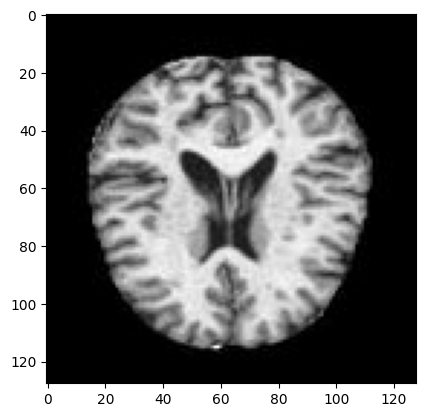

Label: [2 0 3 3 2 2 2 2 3 2 2 1 2 3 2 3 3 0 3 2 3 0 3 2 0 2 2 2 2 3 0 2]


In [ ]:
# Display image and label.
# example = next(iter(dataloader))
example = next(iter(train_ds))
print(len(example))
img = example[0]
label = example[1]

plt.imshow(img[0], cmap="gray") # changed img to img[0] here to fix the dimension error

plt.show()
print(f"Label: {label}")

In [ ]:
print(img[0].shape)
print(img[0])

(128, 128)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(128, 128), dtype=int64)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      3200      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 256)       0

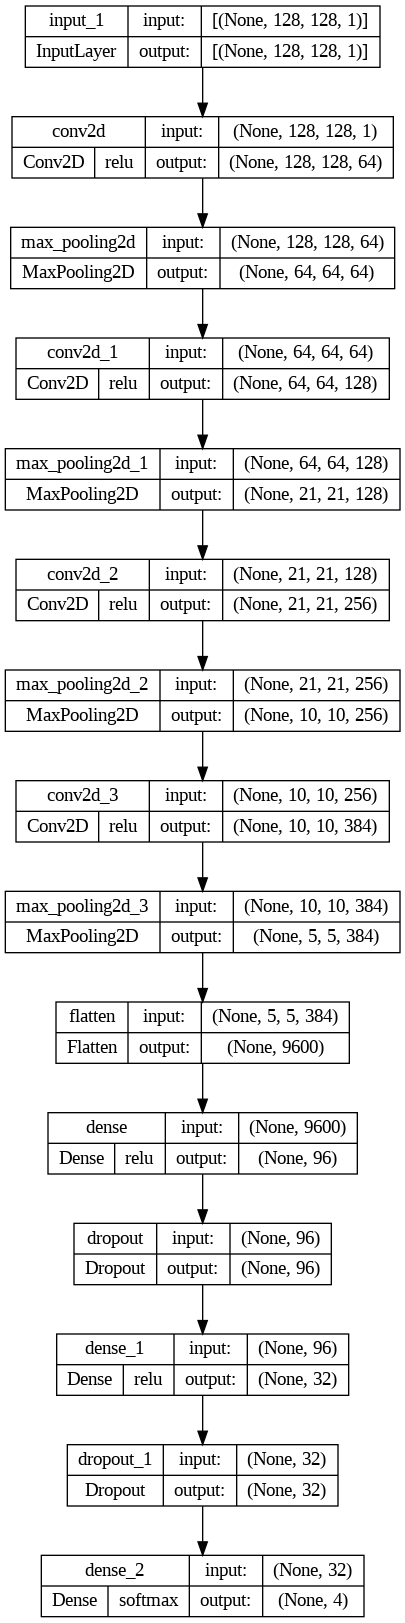

In [ ]:
# Model
model = keras.models.Sequential([
    keras.Input(shape=(128,128, 1)),
    keras.layers.Conv2D(64, 7, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 5, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(3),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(384, 2, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(96, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation="softmax")
                                    ])
model.summary()
keras.utils.plot_model(model, "my_model.png", show_shapes=True, show_layer_activations=True)

In [ ]:
myEpochs = 50
myOptimizer = "adam"
myLoss = "sparse_categorical_crossentropy"
myMetrics = ["accuracy"]

In [ ]:
my_callbacks = [keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=3, min_delta=0.01),
                keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=6, restore_best_weights=True)]


# my_callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=6, restore_best_weights=True)]

In [ ]:
model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics)
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs = myEpochs,
                    callbacks=my_callbacks)

Epoch 1/50
160/160 [==============================] - 17s 54ms/step - loss: 1.9031 - accuracy: 0.4348 - val_loss: 1.0687 - val_accuracy: 0.4953 - lr: 0.0010
Epoch 2/50
160/160 [==============================] - 7s 45ms/step - loss: 1.1020 - accuracy: 0.4695 - val_loss: 0.9780 - val_accuracy: 0.4953 - lr: 0.0010
Epoch 3/50
160/160 [==============================] - 8s 47ms/step - loss: 1.0395 - accuracy: 0.5070 - val_loss: 1.0139 - val_accuracy: 0.5477 - lr: 0.0010
Epoch 4/50
160/160 [==============================] - 8s 49ms/step - loss: 1.0003 - accuracy: 0.5250 - val_loss: 0.9405 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 5/50
160/160 [==============================] - 7s 44ms/step - loss: 0.9688 - accuracy: 0.5424 - val_loss: 0.9125 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 6/50
160/160 [==============================] - 8s 51ms/step - loss: 0.9229 - accuracy: 0.5738 - val_loss: 0.8745 - val_accuracy: 0.5914 - lr: 0.0010
Epoch 7/50
160/160 [==============================] - 8s 48ms/s

In [ ]:
model.save('CNN_model_1.keras')

In [ ]:
# run this if you have CNN_model_1.keras saved, and don't want to go through training again

from tensorflow.keras.models import load_model

model = load_model('CNN_model_1.keras')

In [ ]:
print(img[0].shape)

(128, 128)


#Transfer Learning Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
img_height, img_width = img[0].shape

# Load pre-trained VGG16 model without the top (fully connected) layers
base_model = EfficientNetV2S(weights='imagenet',
                   include_top=False,
                   input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False


82420632/82420632 [==============================] - 0s 0us/step


In [ ]:
num_classes = 4

input_tensor = Input(shape=(img_height, img_width, 1))
x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(input_tensor)


# x = base_model(x)
# x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)


x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)


predictions = Dense(num_classes, activation='softmax')(x)


# Create the transfer learning model
model = Model(inputs=input_tensor, outputs=predictions)

# Compile the model
model.compile(optimizer=RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 3)       30        
                                                                 
 efficientnetv2-s (Function  (None, 4, 4, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_3 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_4 (Dense)             (None, 4)                 4100  

In [ ]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_delta=0.01)
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=6, restore_best_weights=True)

# Train the model

history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[early_stop])

# Save the model
# model.save('transfer_learning_model.h5')


Epoch 1/50
160/160 [==============================] - 49s 176ms/step - loss: 1.0683 - accuracy: 0.5131 - val_loss: 0.9761 - val_accuracy: 0.5078
Epoch 2/50
160/160 [==============================] - 23s 146ms/step - loss: 0.9156 - accuracy: 0.5590 - val_loss: 0.9247 - val_accuracy: 0.5250
Epoch 3/50
160/160 [==============================] - 24s 148ms/step - loss: 0.8879 - accuracy: 0.5684 - val_loss: 0.9311 - val_accuracy: 0.5375
Epoch 4/50
160/160 [==============================] - 23s 144ms/step - loss: 0.8518 - accuracy: 0.5998 - val_loss: 0.8995 - val_accuracy: 0.5484
Epoch 5/50
160/160 [==============================] - 24s 148ms/step - loss: 0.8393 - accuracy: 0.5957 - val_loss: 0.8829 - val_accuracy: 0.5672
Epoch 6/50
160/160 [==============================] - 23s 144ms/step - loss: 0.8124 - accuracy: 0.6141 - val_loss: 0.8522 - val_accuracy: 0.5914
Epoch 7/50
160/160 [==============================] - 23s 146ms/step - loss: 0.7989 - accuracy: 0.6277 - val_loss: 0.8283 - val_ac

In [ ]:
# Fine-Tune transfer learning model

# Unfreeze the layers
base_model.trainable = True

model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_phase_2 = model.fit(train_ds, validation_data=test_ds, epochs=15, callbacks=[early_stop])


139/160 [=========================>....] - ETA: 4s - loss: 0.1486 - accuracy: 0.9458

KeyboardInterrupt: 

In [ ]:
model.save('transfer_learning_model.h5')
